In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA


In [23]:
historic_df = pd.read_csv(r'Base de Dados//Dados Históricos - Ibovespa.csv', parse_dates=['Data'], index_col='Data')

historic_df['Var%'] = historic_df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

historic_df['Vol.'] = historic_df['Vol.'].str.replace(',', '.')
historic_df['Vol.'] = historic_df['Vol.'].apply(
    lambda x: float(str(x)[:-1].replace(',', '.'))/1_000  if str(x)[-1] == 'K'
    else float(str(x)[:-1].replace(',', '.')) if str(x)[-1] == 'M'
    else float(str(x)[:-1].replace(',', '.')) * 1_000 if str(x)[-1] == 'B'
    else float(str(x).replace(',', '.'))/1_000_000 )

historic_df.rename(columns={'Vol.':'Vol (M)'}, inplace=True)

C:\Users\dhlui\AppData\Local\Temp\ipykernel_16716\1969224291.py:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  historic_df = pd.read_csv(r'Base de Dados//Dados Históricos - Ibovespa.csv', parse_dates=['Data'], index_col='Data')


In [24]:
historic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2025-03-17 to 2023-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    550 non-null    float64
 1   Abertura  550 non-null    float64
 2   Máxima    550 non-null    float64
 3   Mínima    550 non-null    float64
 4   Vol (M)   550 non-null    float64
 5   Var%      550 non-null    float64
dtypes: float64(6)
memory usage: 30.1 KB


In [25]:
historic_df.describe()

,Último,Abertura,Máxima,Mínima,Vol (M),Var%
count,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000
mean,121.529976,121.491845,122.316922,120.733245,918.218364,0.036691
std,9.002357,9.007406,8.917136,9.071973,3043.315581,0.974496
min,97.926000,97.926000,99.258000,96.997000,4.330000,-3.150000
25%,115.940000,115.910750,116.929750,115.500250,9.070000,-0.577500
50%,124.307000,124.247000,124.898500,123.414500,10.760000,0.015000
75%,128.158000,128.154000,128.983000,127.405500,13.275000,0.650000
max,137.344000,137.349000,137.469000,136.664000,24870.000000,4.290000


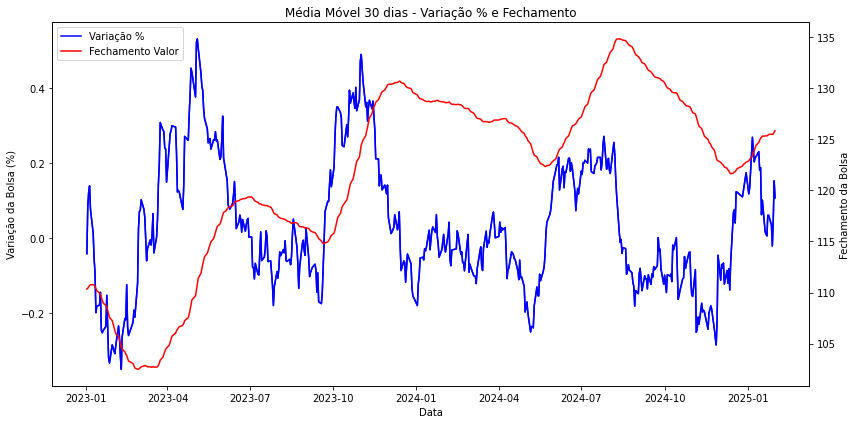

In [47]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot da média móvel da variação percentual no eixo primário
line1, = ax.plot(historic_df.index, historic_df['Var%'].rolling(window=30).mean(), color='blue', label='Variação %')
ax.plot(historic_df.index, historic_df['Var%'].rolling(window=30).mean(), color='blue', label='Variação %')
ax.set_xlabel('Data')
ax.set_ylabel('Variação da Bolsa (%)')
ax.tick_params(axis='y')

# Criação do segundo eixo Y (para o fechamento da bolsa)
line2, = ay.plot(historic_df.index, historic_df['Último'].rolling(window=30).mean(), color='red', label='Fechamento Valor')
ay = ax.twinx()
ay.plot(historic_df.index, historic_df['Último'].rolling(window=30).mean(), color='red', label='Fechamento Valor')
ay.set_ylabel('Fechamento da Bolsa')
ay.tick_params(axis='y')

# Título e layout
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')  # você pode ajustar o loc conforme preferir

plt.title('Média Móvel 30 dias - Variação % e Fechamento')
fig.tight_layout()

# Exibir gráfico
plt.show()


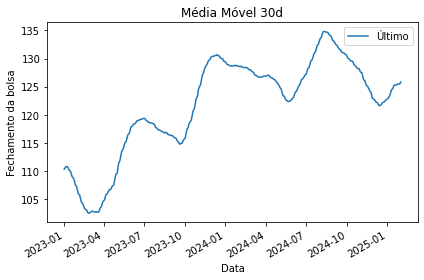

In [ ]:

ax.set_title('Média Móvel 30d')
ax.set_xlabel('Data')
ax.set_ylabel('Fechamento da bolsa')
ax.get_figure().set_tight_layout(True)

In [35]:
historic_var_df = historic_df[['Var%']]
X = historic_var_df[['Var%']].values

result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")


Teste ADF
Teste Estatístico: -17.369814048952968
P-Value: 5.145576157048985e-30
Valores críticos:
	1%: -3.442339408568417
	5%: -2.866828612425054
	10%: -2.5695866531248335
